<a href="https://colab.research.google.com/github/olesyamba/Risk_analysis/blob/main/market_risks_value_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Добавляем YahooFinance и Pandas версии 1.2+

!pip install yfinance
!pip install --upgrade pandas>=1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Импортируем библиотеки

import yfinance as yf
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt

In [ ]:
# Данные: Apple

quotes = yf.download("AAPL", "2016-01-01", "2020-12-31")
prices = quotes['Adj Close']

[*********************100%***********************]  1 of 1 completed


Изучим данные на предмет стационарности.

 **Стационарность** - ключевое условие осмысленности статистического анализа и надежности оценок на его основе.  


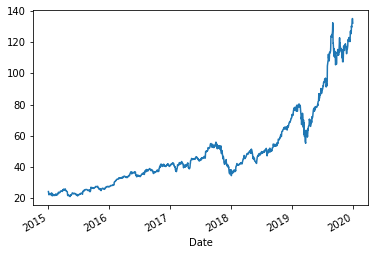

In [ ]:
# Визуальный анализ временного ряда

prices.plot()

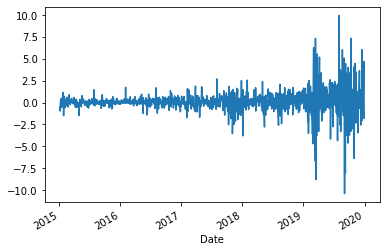

In [ ]:
# Визуальный анализ приращений (первые разности)

prices.diff().plot()

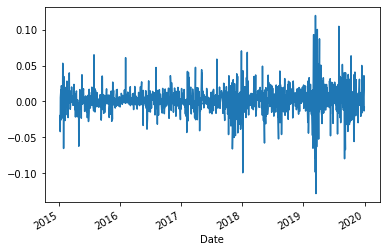

In [ ]:
# Визуальный анализ относительных приращений (доходности)

prices.pct_change().plot()

In [ ]:
# Эмпирическая оценка
# Общепринятое название метод Исторического моделирования, Historical Simulation (сокращение HS)

def calculate_VaR_HS(returns, level):
  return - returns.quantile(1 - level, interpolation='higher')

In [ ]:
level = 0.99
returns = prices.pct_change().dropna().rename('Returns')

print('VaR_{:.0%} = {:.2%}'.format(level, calculate_VaR_HS(returns, level)))

VaR_99% = 5.26%


Реализуем расчет VaR в плавающем окне (создадим оконную функцию)

In [ ]:
# Аргументы:
# - ряд значений P&L (например, доходностей)
# - функция расчета VaR (зависит от метода и модели) - например, HS
# - размер исторического окна (сколько последних наблюдений используется для оценки VaR)
# - уровень надежности VaR (параметр, который подставляется в функцию VaR_fun)

def calc_VaR(returns, VaR_fun, window_length, VaR_level):
  VaR = np.full(returns.size, np.nan)

  for i in range(window_length, len(returns)):
    history = returns[i - window_length : i]
    VaR[i] = VaR_fun(history, VaR_level)

  return pd.Series(data=VaR, index=returns.index, name=VaR_fun.__name__)

In [ ]:
VaR_HS = calc_VaR(returns, calculate_VaR_HS, 50, level)
print(VaR_HS.dropna())

Date
2016-03-17 00:00:00-04:00    0.042205
2016-03-18 00:00:00-04:00    0.042205
2016-03-21 00:00:00-04:00    0.042205
2016-03-22 00:00:00-04:00    0.026708
2016-03-23 00:00:00-04:00    0.026708
                               ...   
2020-12-23 00:00:00-05:00    0.046312
2020-12-24 00:00:00-05:00    0.046312
2020-12-28 00:00:00-05:00    0.046312
2020-12-29 00:00:00-05:00    0.046312
2020-12-30 00:00:00-05:00    0.046312
Name: calculate_VaR_HS, Length: 1207, dtype: float64


Функцию можно построить на встроенных методах rolling из DataFrame, но они корректно работую в версиях pandas 1.2 и выше.


In [ ]:
def calc_VaR_2(returns, VaR_fun, window_length, VaR_level):
    return returns.rolling(window=window_length, closed='left').apply(
        VaR_fun, kwargs={'level': VaR_level}
    )
VaR_HS_2 = calc_VaR_2(returns, calculate_VaR_HS, 252, level)

# Проверим одинаковы ли вектора оценок VaR для двух версий функций
VaR_HS.equals(VaR_HS_2)
# VaR_HS == VaR_HS_2


True

In [ ]:
a = pd.Series([0,1,2,3,4,5,6,7,8,9,10,11, 12])
t1 = a.rolling(window=4, closed='left').apply(max)
t2 = a.rolling(window=4).apply(max) # by default closed = 'right'
display(pd.DataFrame({'Data': a, 'Max with closed=Left': t1, 'Max with closed=Right (default parameter)': t2}))

,Data,Max with closed=Left,Max with closed=Right (default parameter)
0,0,NaN,NaN
1,1,NaN,NaN
2,2,NaN,NaN
3,3,NaN,3.0
4,4,3.0,4.0
5,5,4.0,5.0
6,6,5.0,6.0
7,7,6.0,7.0
8,8,7.0,8.0
9,9,8.0,9.0


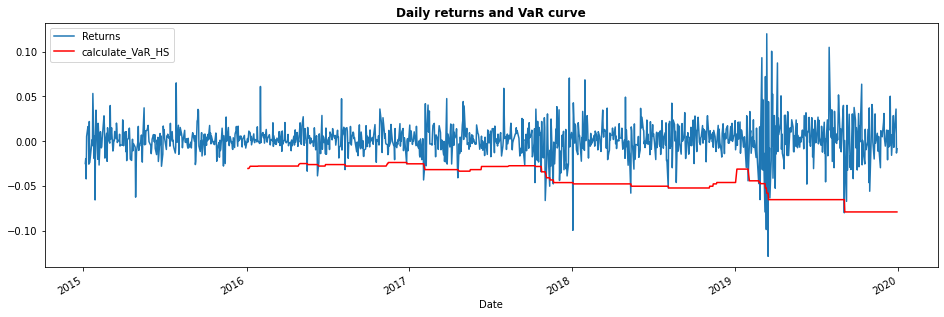

In [ ]:
# Изобразим графически

fig = plt.figure(figsize=(16, 5))

returns.plot()
(-VaR_HS).plot(color="r")

plt.title("Daily returns and VaR curve", weight="bold")
plt.legend()
plt.show()

In [ ]:
# Параметрический метод (с ним связан метод Дельта-нормальный)

def calculate_VaR_normal(returns, level):
  params = ss.norm.fit(returns)
  return -ss.norm.ppf(1 - level, *params)

VaR_norm = calc_VaR(returns, calculate_VaR_normal, 50, level)

In [ ]:
def calculate_VaR_t(returns, level):
    params_t = ss.t.fit(returns)
    return -ss.t.ppf(1 - level, *params_t)

VaR_t = calc_VaR(returns, calculate_VaR_t,  window_length=50, VaR_level=level)

In [ ]:
# dist - распределение из stats (from scipy)

# def calculate_VaR_param(returns, level, dist):
#     params_t = dist.fit(returns)
#     return -dist.ppf(1 - level, *params_t)


# VaR_t = calc_VaR(returns, calculate_VaR_t,  window_length=252, VaR_level=level)

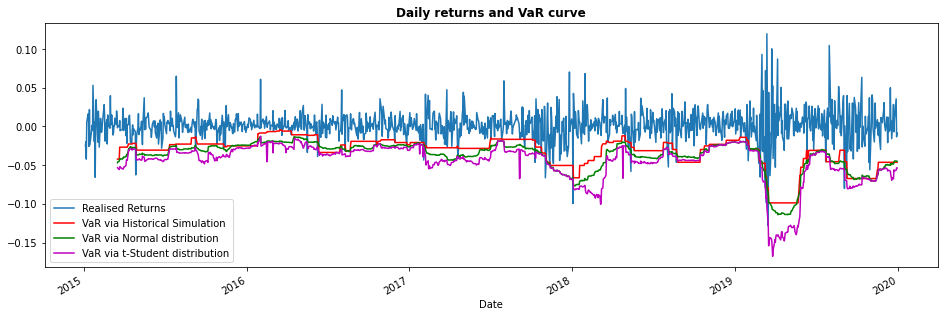

In [ ]:
# Изобразим графически

fig = plt.figure(figsize=(16, 5))
returns.plot()

(-VaR_HS).plot(color="r") # Исторический метод
(-VaR_norm).plot(color="g") # Параметрический (нормальный)
(-VaR_t).plot(color="m") # Параметрический (Стьюдент)

plt.title("Daily returns and VaR curve", weight="bold")
plt.legend(
    [
        "Realised Returns",
        "VaR via Historical Simulation",
        "VaR via Normal distribution",
        "VaR via t-Student distribution",
    ]
)
plt.show()

Возьмем рыночные данные другой природы. Процентые ставки - факторы стоимости облигаций.

[*********************100%***********************]  1 of 1 completed


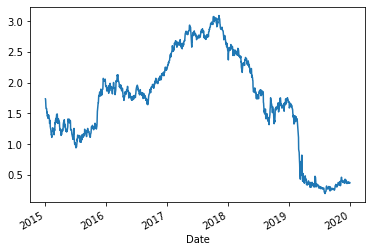

In [ ]:
# Скачаем 5летние процентные ставки государственных облигаций США

quotes = yf.download('^FVX', "2016-01-01", "2020-12-31")
rates = quotes['Adj Close']
rates.plot()

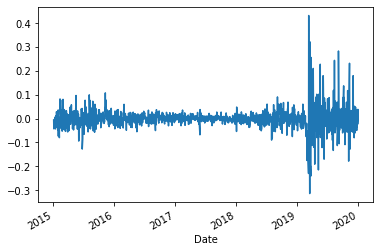

In [ ]:
rates.pct_change().plot()

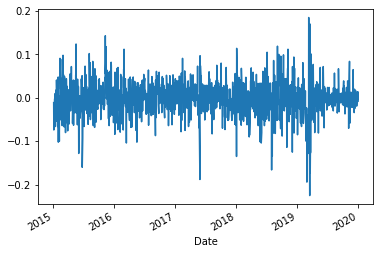

In [ ]:
rates.diff().plot()

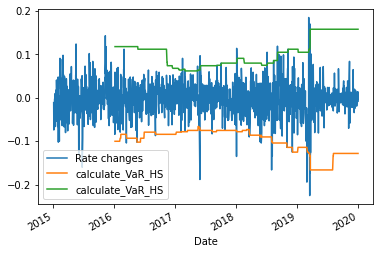

In [ ]:
# Особенность исторического метода (ассиметричен)

diffs = rates.diff().dropna().rename('Rate changes')
quantile_lower = calc_VaR(diffs, calculate_VaR_HS, 252, level)
quantile_upper = - calc_VaR(-diffs, calculate_VaR_HS, 252, level)

# Рассмотрим оценки квантилей с двух сторон
diffs.plot()
(-VaR_lower).plot()
VaR_upper.plot()
plt.legend()

Все ряды демонстрируют нестационарность - кластеризацию волатильности (то высокая, то низкая).

Расчет в плавающем окне дает возможности модели адаптироваться. Однако в качестве альтернативы стоит рассматривает моделирование временного ряда с непостоянной дисперсией.

Существует специальный класс моделей ARCH/GARCH ([ссылка](https://arch.readthedocs.io/en/latest/index.html) на мануал к библиотеке).

Основная идея модели GARCH(1,1):

$$r_t∼ N(0, \sigma_t^2)$$
$$σ_t^2 = \omega + \alpha r_{t-1}^2  + \beta \sigma^2_{t-1}$$



In [ ]:
!pip install arch
import arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


GARCH умеет работать с различными базовыми распределениями. Попробуем разные варинаты!

Iteration:      1,   Func. Count:      6,   Neg. LLF: 224099.7142740958
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2641.6346724419905
Iteration:      3,   Func. Count:     20,   Neg. LLF: 2499.40466125416
Iteration:      4,   Func. Count:     26,   Neg. LLF: 2457.3878323504287
Iteration:      5,   Func. Count:     32,   Neg. LLF: 680238417.0564568
Iteration:      6,   Func. Count:     38,   Neg. LLF: 2423.575041246112
Iteration:      7,   Func. Count:     44,   Neg. LLF: 2428.277478515801
Iteration:      8,   Func. Count:     50,   Neg. LLF: 2399.17233482772
Iteration:      9,   Func. Count:     55,   Neg. LLF: 2399.0900052481848
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2399.086694584098
Iteration:     11,   Func. Count:     65,   Neg. LLF: 2399.0866602457145
Iteration:     12,   Func. Count:     69,   Neg. LLF: 2399.08666024607
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2399.0866602457145
            Iterations: 12

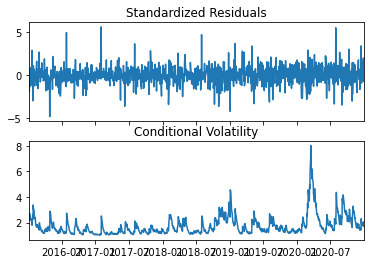

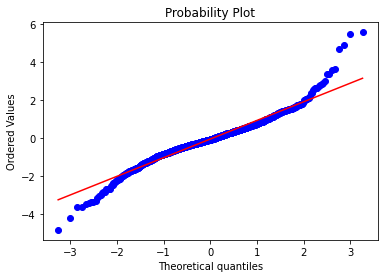

In [ ]:
# Базовое распределение - нормальное (оно - параметр по умолчанию)

mdl = arch.arch_model(returns * 100).fit()

forecast = mdl.forecast(reindex=False)
print('Среднее: {:.2f},\nВолатильность {:.2f}'.format(forecast.mean.iloc[0,0], forecast.variance.iloc[0,0]))

mdl.plot()
plt.figure()
ss.probplot(mdl.std_resid, plot=plt);


Остатки не стали нормальными, значит, дело не только в изменении волатильности.

Заменим базовое распределение.

Iteration:      1,   Func. Count:      7,   Neg. LLF: 33885.316051592265
Iteration:      2,   Func. Count:     16,   Neg. LLF: 19911.465221542363
Iteration:      3,   Func. Count:     24,   Neg. LLF: 3497.8894209287655
Iteration:      4,   Func. Count:     31,   Neg. LLF: 3366.5078114742673
Iteration:      5,   Func. Count:     38,   Neg. LLF: 6290.03404959002
Iteration:      6,   Func. Count:     45,   Neg. LLF: 2314.0339750496555
Iteration:      7,   Func. Count:     51,   Neg. LLF: 3194.9712851824097
Iteration:      8,   Func. Count:     58,   Neg. LLF: 2507.042482309723
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2312.982435773444
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2312.645066539746
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2312.629249022183
Iteration:     12,   Func. Count:     86,   Neg. LLF: 2312.6268233244537
Iteration:     13,   Func. Count:     92,   Neg. LLF: 2312.6266600059253
Iteration:     14,   Func. Count:     98,   Neg. LLF: 231

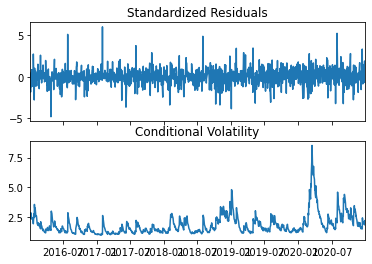

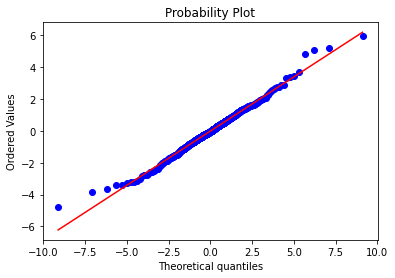

In [ ]:
# Попробуем воспользоваться распределением Стьюдента

mdl = arch.arch_model(returns * 100, dist='t').fit()

forecast = mdl.forecast(reindex=False)
print(mdl)
print('Среднее: {:.2f},\nВолатильность {:.2f}'.format(forecast.mean.iloc[0,0], forecast.variance.iloc[0,0]))

mdl.plot()
plt.figure()
ss.probplot(mdl.std_resid, dist=ss.t(df=mdl.params['nu']), plot=plt);

Гораздо лучше! 😀

In [ ]:
# Добавим функцию оценки VaR с помощтю модели GARCH (пусть распределение Стьюдента будет фиксировано для простоты)

def calculate_VaR_GARCH(returns, level):
  K = 100
  mdl = arch.arch_model(returns * K, dist='t')
  res = mdl.fit(disp='off')
  forecast = res.forecast(reindex=False)
  mu = forecast.mean.iloc[0,0]
  sigma = np.sqrt(forecast.variance.iloc[0,0])
  q = mdl.distribution.ppf(1 - level, res.params['nu'])
  return - (mu + sigma * q)/K

calculate_VaR_GARCH(returns, level)

0.05074632543325759

In [ ]:
# Добавим прогресс бар, чтобы отслеживать как продвигаются расчеты
from tqdm import trange

def calc_VaR(returns, VaR_fun, window_length, VaR_level):
    VaR = np.full(returns.size, np.nan)

    for i in trange(window_length, len(returns)):
        history = returns[i - window_length : i]
        VaR[i] = VaR_fun(history, VaR_level)

    return pd.Series(data=VaR, index=returns.index, name=VaR_fun.__name__)

In [ ]:
VaR_GARCH = calc_VaR(returns, calculate_VaR_GARCH, 252, level)
VaR_GARCH

100%|██████████| 1005/1005 [00:52<00:00, 19.18it/s]


Date
2016-01-05 00:00:00-05:00         NaN
2016-01-06 00:00:00-05:00         NaN
2016-01-07 00:00:00-05:00         NaN
2016-01-08 00:00:00-05:00         NaN
2016-01-11 00:00:00-05:00         NaN
                               ...   
2020-12-23 00:00:00-05:00    0.054505
2020-12-24 00:00:00-05:00    0.051868
2020-12-28 00:00:00-05:00    0.048908
2020-12-29 00:00:00-05:00    0.056756
2020-12-30 00:00:00-05:00    0.055683
Name: calculate_VaR_GARCH, Length: 1257, dtype: float64

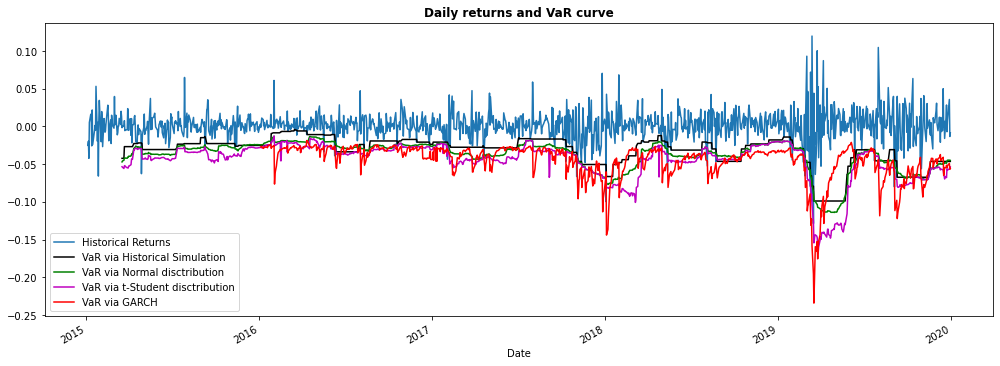

In [ ]:
fig = plt.figure(figsize=(17, 6))
returns.plot()
(-VaR_HS).plot(color="k")
(-VaR_norm).plot(color="g")
(-VaR_t).plot(color="m")
(-VaR_GARCH).plot(color="r")
plt.title("Daily returns and VaR curve", weight="bold")
plt.legend(
    [
        "Historical Returns",
        "VaR via Historical Simulation",
        "VaR via Normal disctribution",
        "VaR via t-Student disctribution",
        "VaR via GARCH",
    ]
)
plt.show()